<a href="https://colab.research.google.com/github/fwkhan/CE802/blob/master/Classification_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Reading Training and Test .CSV
  

In [ ]:
train_data = pd.read_csv('CE802_P2_Data.csv')
final_test_data  = pd.read_csv('CE802_P2_Test.csv')
test_data = final_test_data.copy()
column_name = train_data.columns


# Data Analysis

### Function to print Data Info
This function takes all the columns and print their info sequentially


In [ ]:
def print_data_info(train_data, col_name):
  """ 
    Prints information about train or test data. 

    This function prints information of each feature of a DataFrame, giving
    details about dtype, describe, min value, max value and null counts. 

    Parameters: 
    train_data (DataFrame): Input Training Data set  
    col_name   (str): Name of a feature

    Returns: No return Value
    
  """  
  print(f'*********Data Info************')
  print(f'***********{col_name}***************')
  print(f'data type  = {train_data[col_name].dtype}')
  print(f'Description  = {train_data[col_name].describe()}')
  print(f'MIN Value  = {train_data[col_name].min()}')
  print(f'MAX Value  = {train_data[col_name].max()}')
  print(f'NULL Values  = {train_data[col_name].isnull().sum()}')

## Train Data Analysis
Total Samples - 1500 


---Total Features - 15

*   F1 - F14 - No Null Values
*   F15 has 750 Null Values

*   F1,F2,F5 - int64
*   Column 'Class' to be predicted True/False










In [ ]:
# Analysis of train data showing info and null count
print(f'{train_data.info(null_counts=False)}')
print(f'Null Value Information')
print(f'{train_data.isnull().sum()}')
# Printing information about each feature in loop.
for col_name in train_data.columns:
  print_data_info(train_data, col_name)
  

##Scatter plots highlight the distribution of data per class basis.


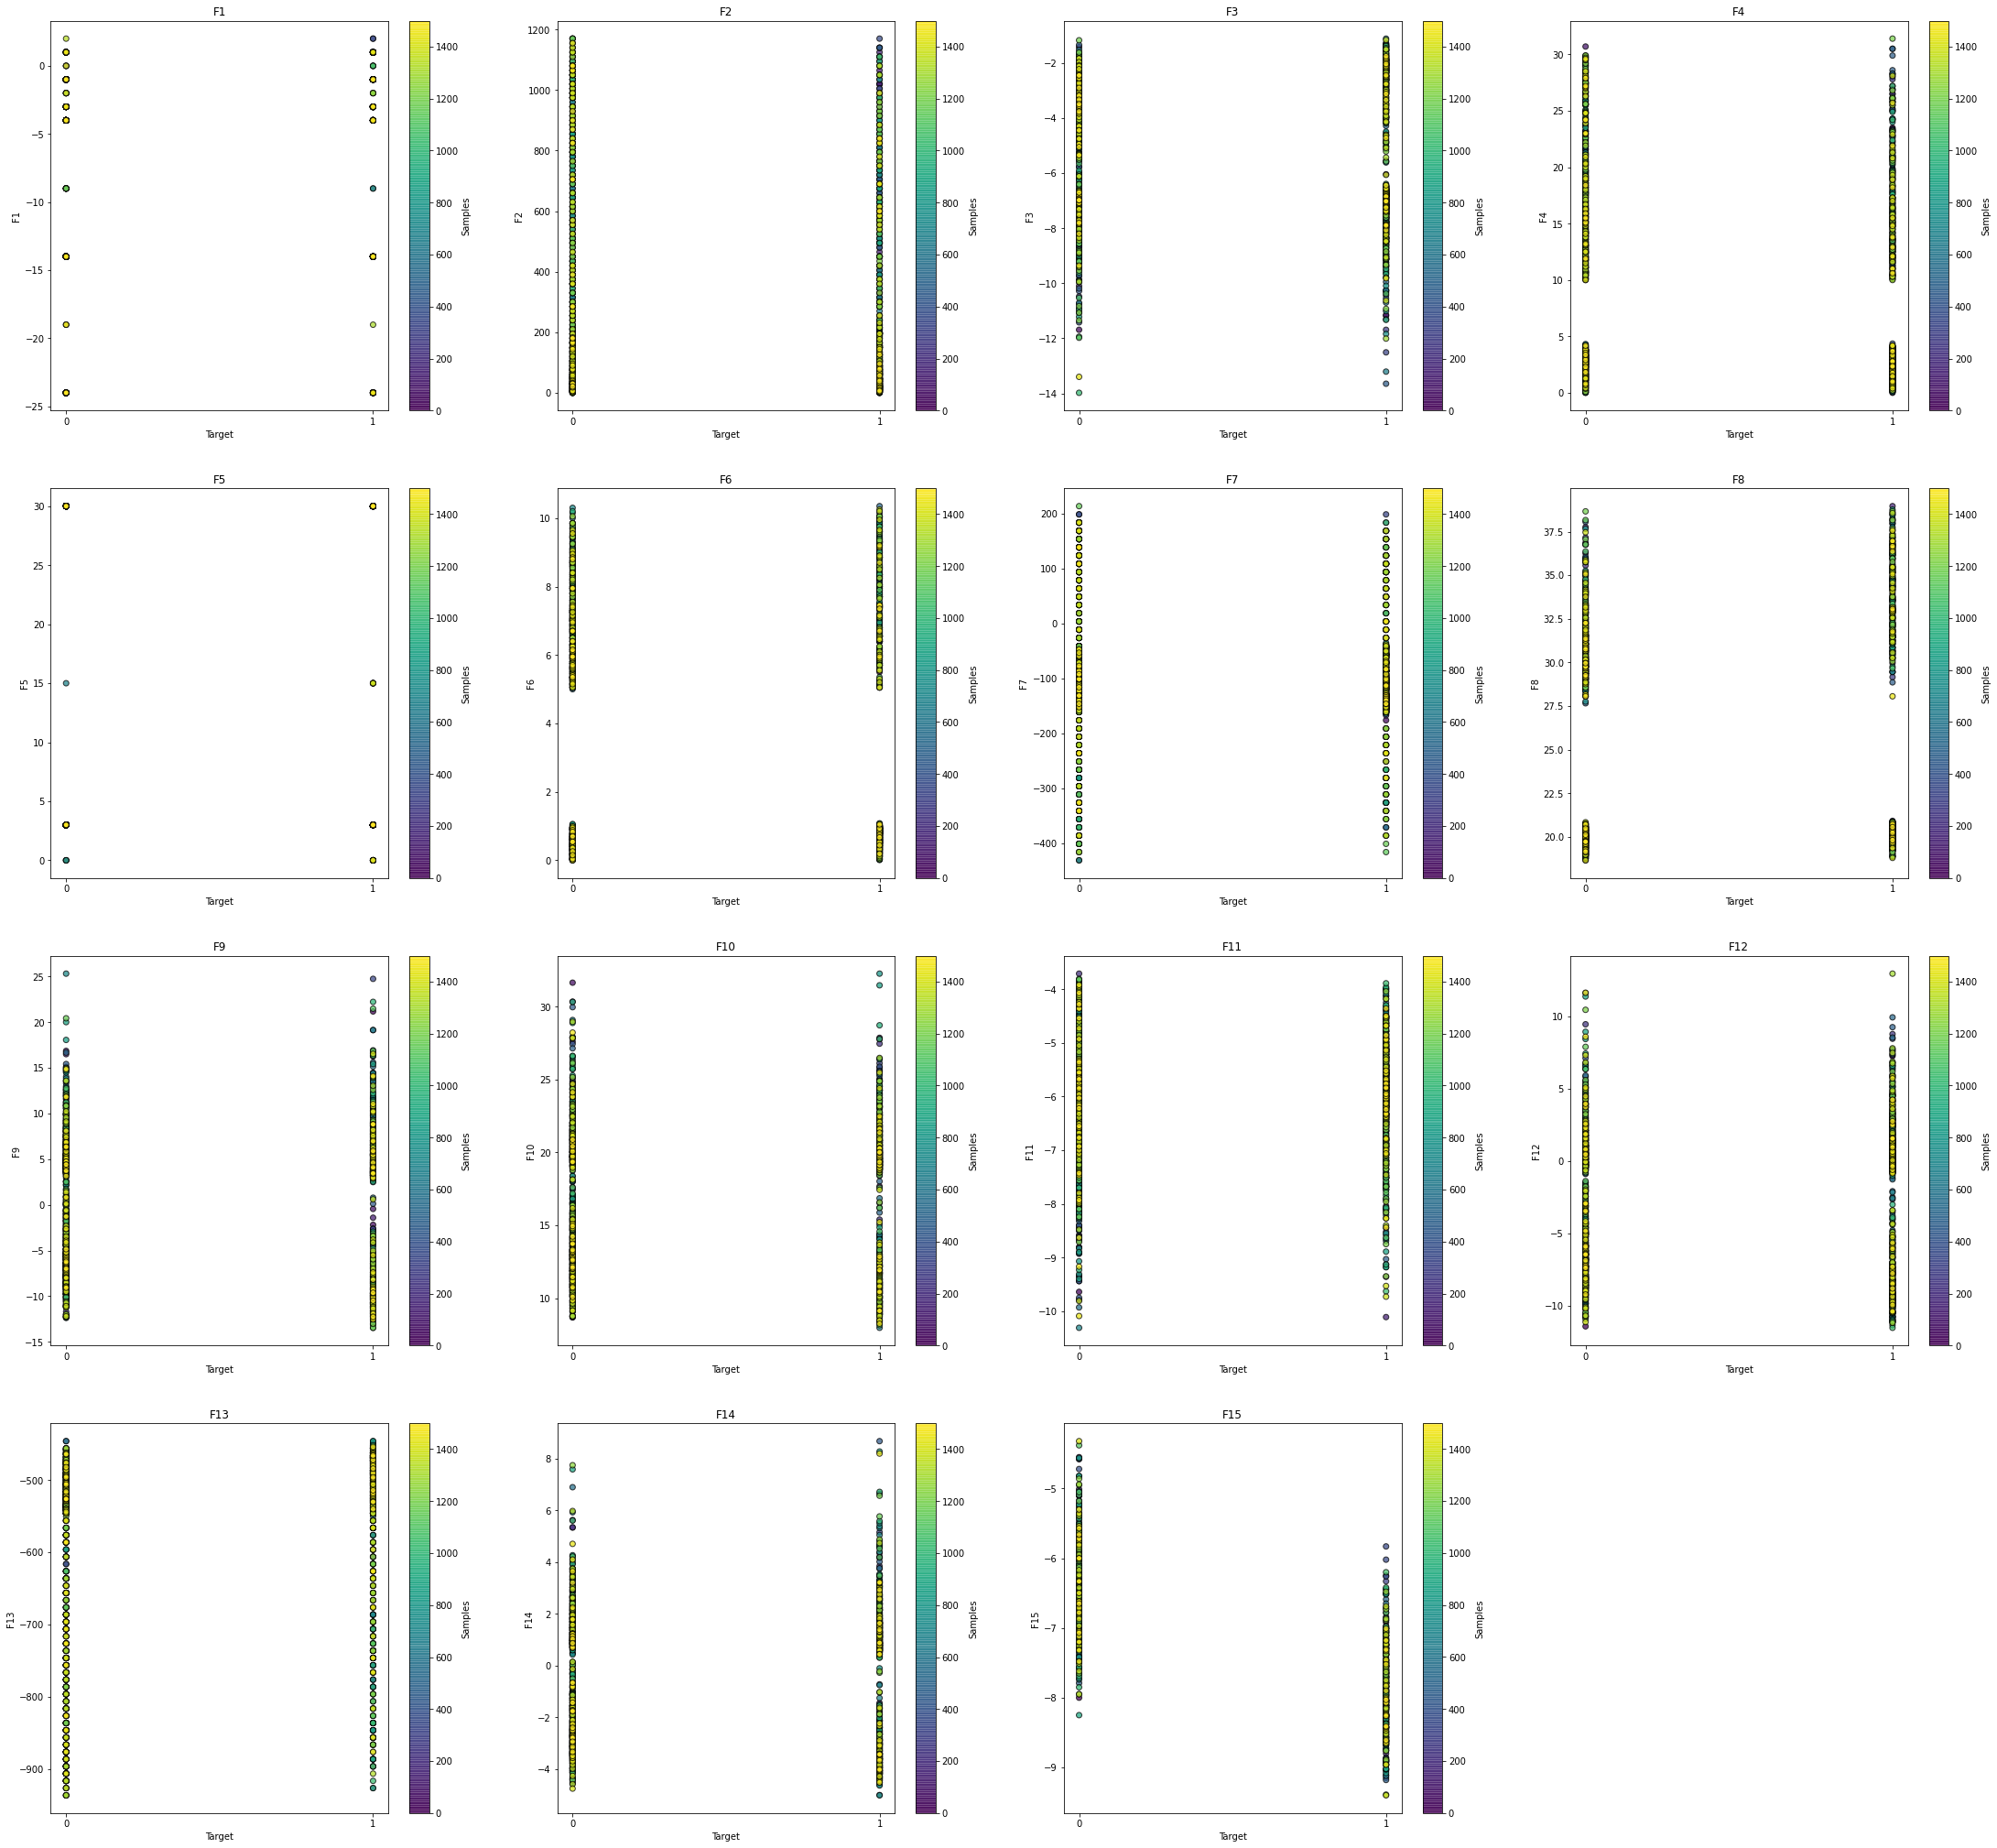

In [ ]:
import matplotlib.pyplot as plt
x = train_data.iloc[:,:-1]
y = train_data['Class']
plt.figure(figsize=(38,36))

color = []
for sample in range(0,1500):
  color.append(sample)  # Marking samples with different color
for i in range(x.shape[1]):
    plt.subplot(4, 4, i+1)
    plt.scatter(y,x.iloc[:,i], c=color, edgecolors='black', linewidths=1, alpha=0.75)

    plt.xticks([0, 1])
    plt.title(train_data.columns[i])
    plt.ylabel(train_data.columns[i])
    plt.xlabel('Target')
    cbar = plt.colorbar()
    cbar.set_label('Samples')

##Histogram showing feature F15 has missing values.

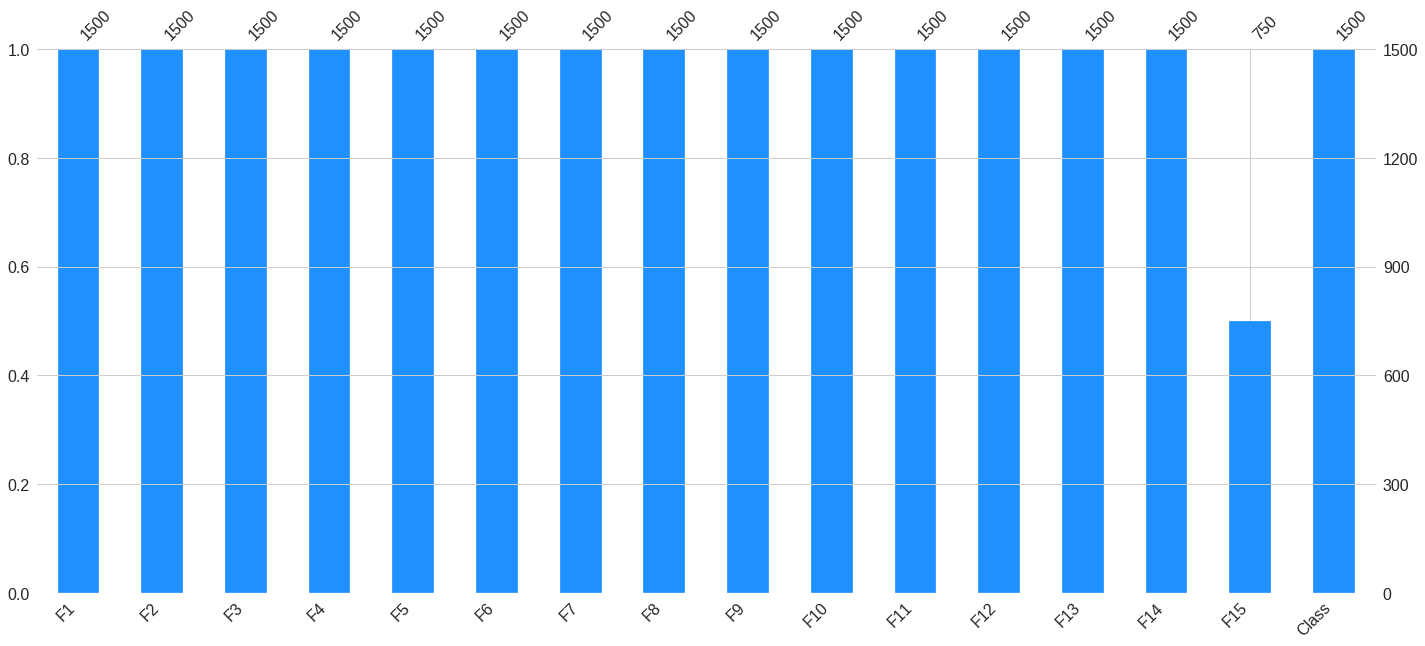

In [ ]:
import missingno as msno
msno.bar(train_data, color='dodgerblue')


##Boxplot of Data distribution and Outliers presence

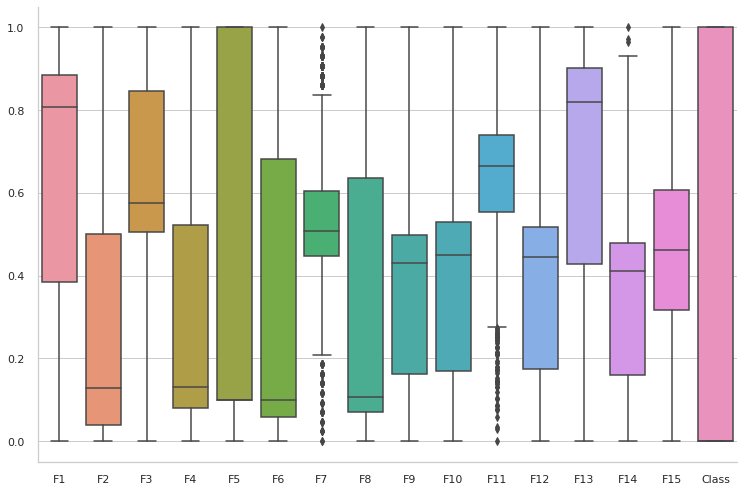

In [ ]:
import seaborn as sns
data = train_data.copy()
# Copy of Train Data is scaled just for plotting, otherwise the plot is
# difficult to analyze because of the difference in range of numerical values.
scalar = MinMaxScaler()
data = scalar.fit_transform(train_data.values.reshape(-1, len(train_data.columns)))
data = pd.DataFrame(data, columns=train_data.columns)

sns.set_theme(style="whitegrid")
ax = sns.catplot(data=data, kind="box",
                height=7, aspect=1.5)


## Bar plot highlighting Class distribution

False    809
True     691
Name: Class, dtype: int64


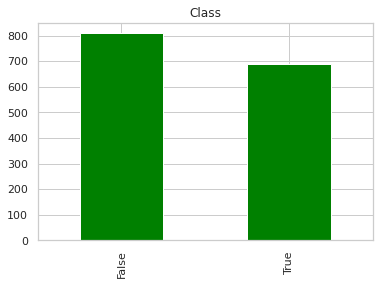

In [ ]:
#Let's plot the above date from "Class" columns in bar plot for better vizualization
print(train_data.Class.value_counts())
train_data.Class.value_counts().plot(kind = 'bar', title = 'Class', color=["green"])

## Test Data Analysis
Total Samples - 1500 


---Total Features - 15

*   F1 - F14 - No Null Values
*   F15 has 750 Null Values

*   F1,F2,F5 - int64
*   Column 'Class' to be predicted True/False





*   F5 - int64




In [ ]:
print(f'{test_data.info(null_counts=False)}')
print(f'Null Value Information')
print(f'{test_data.isnull().sum()}')
# Printing information about each feature in loop.
for col_name in test_data.columns:
  print_data_info(test_data, col_name)
  

## Heatmap for Correlation between different Columns 





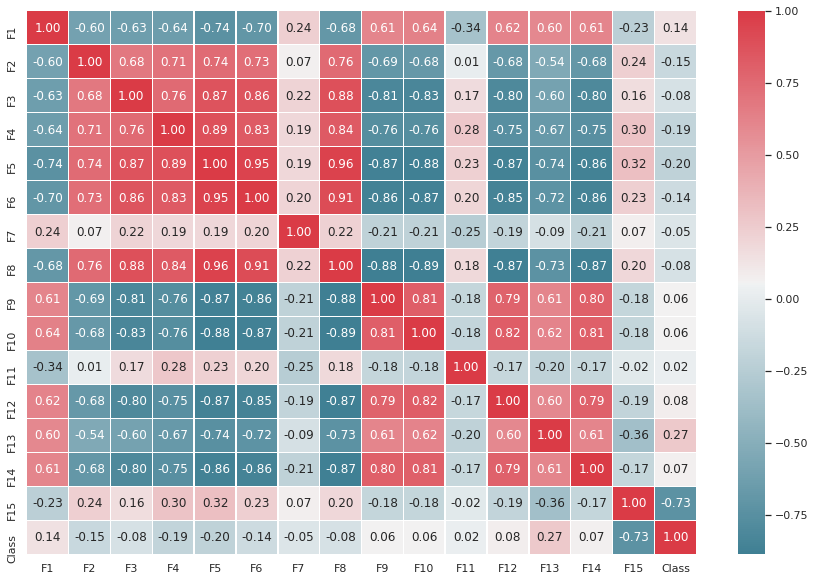

In [ ]:
#Correlation analysis using Seaborn heatmap for data analysis
corr_matrix=train_data.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
fig,ax=plt.subplots(figsize=(15,10))
ax=sns.heatmap(corr_matrix,
              annot=True,
              linewidths=0.5,
              fmt=".2f",
              cmap=colormap);

# Data Preprocessing

##Class to clip Outliers

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from statistics import median
import numpy as np
# This class in based on the Exercie-3 of Machine learning Lab-3

class ThressholdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, qoffset=1.5):
        self.qoffset = qoffset
        self.lower = 0
        self.upper = 0
        self.iqr = 0
        self.outlier_columns = []
        self.lower_limit = {}
        self.upper_limit = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=column_name)
        for col_name in X.columns:
          Q1 = X[col_name].quantile(0.01)
          Q3 = X[col_name].quantile(0.9)
          IQR = Q3-Q1
          self.lower_limit[col_name] = Q1 - self.qoffset*IQR
          self.upper_limit[col_name] = Q3 + self.qoffset*IQR
          if (len(X[( X[col_name]<self.lower_limit[col_name]) | (X[col_name] > self.upper_limit[col_name])][col_name])) >= 1:
            self.outlier_columns.append(col_name)
        
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X, columns=column_name)
        for col_name in self.outlier_columns:
          X = X [ ( X[col_name] > self.lower_limit[col_name]) & (X[col_name] < self.upper_limit[col_name])]
        return X

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X, y)

## Converting F1 F2 from int64 to float64
Converting because test file has F1 and F2 as float64

In [ ]:
train_data['F1'] = train_data['F1'].astype(float)
train_data['F2'] = train_data['F2'].astype(float)

## Common API for data imputaion

---Imputation using 
*   Iterative Imputer
*   KNN Imputer
*   Simple Imputer using Mean
*   Dropping entire column with missing values








In [ ]:
imputer_obj = {}
def impute_data(imputer_type, impute_data, strategy='mean', n_neighbors=2 ):
  data = impute_data.drop(columns='Class', axis=1)
  target_data = impute_data['Class']
  if imputer_type == 'remove_column_F15':
    impute_data.drop(columns = 'F15', axis = 1, inplace=True)
    return impute_data
  elif imputer_type == 'iterative_imputer':
    imputer = IterativeImputer(max_iter=10, random_state= 42) 
    data = imputer.fit_transform(data) 
    imputer_obj[imputer_type]  = imputer
  elif imputer_type == 'simple_imputer':
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer.fit(data)
    data = imputer.transform(data)
    imputer_obj[imputer_type]  = imputer
  elif imputer_type == 'knn_imputer':
    imputer = KNNImputer(n_neighbors=n_neighbors)
    data = imputer.fit_transform(data)
    imputer_obj[imputer_type]  = imputer

  data = pd.DataFrame(data,columns=column_name[:-1])
  data['Class'] = target_data

  return data

## Common API for data Scaling
---Scalig using

*   MinMaxScaler
*   StandardScaler
*   Quantile Scaler


In [ ]:
scalar_obj = {}
def normalize_data(normalize_type, data):
  print('\x1b[1;31m'+f'Normalization Type: {normalize_type}'+'\x1b[0m')
  if normalize_type == 'MinMaxScaler':
    scalar = MinMaxScaler()
    data = scalar.fit_transform(data.values.reshape(-1, len(pd.DataFrame(data).columns)))
    scalar_obj[normalize_type]  = scalar
  elif normalize_type == 'StandardScaler':
    scalar = StandardScaler()
    data = scalar.fit_transform(data)
    scalar_obj[normalize_type]  = scalar
  elif normalize_type == 'QuantileScaler' :
    scalar = QuantileTransformer(output_distribution='normal')
    data = scalar.fit_transform(data)
    scalar_obj[normalize_type]  = scalar
  return data

# Performance Modeling

##API to perform Cross-Validation and Grid Search for each Algorithm

In [ ]:
def model_grid_search(model, parameters, X_train, y_train):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  grid_search = GridSearchCV(estimator = model, param_grid = parameters,
                            cv=cv, return_train_score = False, n_jobs = -1,
                            scoring = 'accuracy')
  grid_search.fit(X_train,y_train)
  best_accuracy = grid_search.best_score_
  return  grid_search

#Model Initialization & Parameter Tuning

##Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def dtree_classifier(X_train, y_train, X_test, y_test):
  """ 
    Initialize DecisionTree Classifier. 

    This function initializes the parameters on which Grid Search has to be 
    performed internally calls the api to Grid Search, which returns the best
    estimator for DecisionTree. 

    Parameters: 
    X_train (DataFrame): Input Training Data set  
    y_train (DataFrame): Labelled Training Data 
    X_test (DataFrame): Input Validation Data set
    y_test (DataFrame): Labelled Validation Data


    Returns: 
    classifier_dtree: Best esitmator for DecisionTree 

  """  
  parameters = {'criterion' :['entropy', 'gini'], 'max_depth':range(3,20)}
  model = DecisionTreeClassifier()
  classifier_dtree = model_grid_search(model, parameters, X_train, y_train)
  return classifier_dtree

## SVM Classifier

In [ ]:
from sklearn.svm import SVC
def svm_classifier(X_train, y_train, X_test, y_test):
  # parameters = {'C' :[0.1, 0.2, 1, 10,20,30,35, 45,70,80,90,100], 'kernel' : ['rbf', 'poly']}
  # Cs = np.linspace(1, 5, 30)
  # gamma_range = np.logspace(-9, 3, 13)
  # Best parameters: {'C': 5.0, 'gamma': 0.03981071705534969, 'kernel': 'rbf'}
  # Cs = np.logspace(-1, 3, 5)
  Gs = np.logspace(-7, -0, 6)
  # Cs = np.linspace(0.01, 6, 50) #this is good
  Cs = np.linspace(1, 5, 20)
  # parameters = {'C' : Cs, 'gamma' : ['auto'], 'kernel' : ['rbf', 'poly']}
  parameters = {'C' : [4.789473684210526], 'gamma' : [3.98107171e-02], 'kernel' : ['rbf']}

  
  model = SVC()
  classifier_svm = model_grid_search(model, parameters, X_train, y_train)
  return classifier_svm


In [ ]:
np.logspace(-7, -0, 6)

array([1.00000000e-07, 2.51188643e-06, 6.30957344e-05, 1.58489319e-03,
       3.98107171e-02, 1.00000000e+00])

## Logisitic Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
def logistic_classifier(X_train, y_train, X_test, y_test):
  """ 
    Initialize LogisticRegression Object. 

    This function initializes the parameters on which Grid Search has to be 
    performed internally calls the api to Grid Search, which returns the best
    estimator for LogisticRegression. 

    Parameters: 
    X_train (DataFrame): Input Training Data set  
    y_train (DataFrame): Labelled Training Data 
    X_test (DataFrame): Input Validation Data set
    y_test (DataFrame): Labelled Validation Data


    Returns: 
    classifier_lr: Best esitmator for LogisticRegression 

  """    
  parameters = {'solver' : ['liblinear'],'C':[1,25,50,75,100]}
  model = LogisticRegression()
  classifier_lr = model_grid_search(model, parameters, X_train, y_train)
  return classifier_lr


##Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(X_train, y_train, X_test, y_test):
  """ 
    Initialize RandomForest Classifier Object. 

    This function initializes the parameters on which Grid Search has to be 
    performed internally calls the api to Grid Search, which returns the best
    estimator for RandomForest. 

    Parameters: 
    X_train (DataFrame): Input Training Data set  
    y_train (DataFrame): Labelled Training Data 
    X_test (DataFrame): Input Validation Data set
    y_test (DataFrame): Labelled Validation Data


    Returns: 
    classifier_rf: Best esitmator for RandomForest 

  """     
  parameters = {'criterion' :['entropy'], 'max_depth' : [9]}
  model = RandomForestClassifier()
  classifier_rf = model_grid_search(model, parameters, X_train, y_train)
  return classifier_rf


##XGBOOST Classfier

In [ ]:
from xgboost import XGBClassifier
def xgboost_classifier(X_train, y_train, X_test, y_test):
  """ 
    Initialize XGBoost Classifier. 

    This function initializes the parameters on which Grid Search has to be 
    performed internally calls the api to Grid Search, which returns the best
    estimator for XGBoost. 

    Parameters: 
    X_train (DataFrame): Input Training Data set  
    y_train (DataFrame): Labelled Training Data 
    X_test (DataFrame): Input Validation Data set
    y_test (DataFrame): Labelled Validation Data


    Returns: 
    classifier_xgb: Best esitmator for XGBoost 

  """

  parameters = {'objective':['binary:logistic'],
                'learning_rate': [0.6],
                'n_estimators': [300],
                'n_jobs' : [-1]} 

  model = XGBClassifier()
  classifier_xgb = model_grid_search(model, parameters, X_train, y_train)
  return classifier_xgb



##Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def gradient_boosting_classifier(X_train, y_train, X_test, y_test):
  """ 
    Initialize GradientBoosting Classifier Object. 

    This function initializes the parameters on which Grid Search has to be 
    performed internally calls the api to Grid Search, which returns the best
    estimator for GradientBoosting. 

    Parameters: 
    X_train (DataFrame): Input Training Data set  
    y_train (DataFrame): Labelled Training Data 
    X_test (DataFrame): Input Validation Data set
    y_test (DataFrame): Labelled Validation Data


    Returns: 
    classifier_gradboosting: Best esitmator for GradientBoosting 

  """   
  parameters = {}
  # parameters = {'learning_rate' :[0.1, 0.5, 0.9], 'max_depth' : [3,5,7,9], 'max_features' : ['auto', 'sqrt', 'log2']}
  model = GradientBoostingClassifier()
  classifier_gradboosting = model_grid_search(model, parameters, X_train, y_train)
  return classifier_gradboosting

##Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier 

def stacking_classifier(X_train, y_train, X_test, y_test):
  """ 
    Stacking with different classifiers. 

    This function creates a list of estimators consisting of previously
    trained classifiers. Performs training on training data set and 
    prediction on the validation data set.

    Parameters: 
    X_train (DataFrame): Input Training Data set  
    y_train (DataFrame): Labelled Training Data 
    X_test (DataFrame): Input Validation Data set
    y_test (DataFrame): Labelled Validation Data


    Returns: 
    classifier_gradboosting: Best esitmator for GradientBoosting
    test_score: Score of prediction done on test data
    accuracy_mean: Average Cross Validation Score
    cross_valScore: List of all the Cross Validation Score

  """    
  
  estimators = [
  ('SVM', stack_dict['svm_classifier']),
  ('GRadBoost', stack_dict['gradient_boosting_classifier']),
  ('XGB' ,   stack_dict['xgboost_classifier'])
  ]
  classifier_stacking = StackingClassifier(
  estimators=estimators, final_estimator=stack_dict['logistic_classifier']
  )
  test_score, accuracy_mean, cross_valScore = fit_models(classifier_stacking, X_train, y_train, X_test, y_test)
  classifier_stacking.fit(X_train, y_train)
  predictions = classifier_stacking.predict(X_test)
  matrix = confusion_matrix(y_test, predictions)
  plt.figure(figsize=(10,7))
  sns.heatmap(matrix, annot=True)
  plt.xlabel('predicted')
  plt.ylabel('Truth')
  plt.show()
  return test_score, accuracy_mean, cross_valScore

#Training and Prediction

## Preprocessing strategies

In [ ]:
# imputer_list = ['remove_column_F15', 'iterative_imputer', 'simple_imputer', 'knn_imputer']
imputer_list = ['knn_imputer']

imputer_strategy_list = ['mean']
# scaler_list = ['MinMaxScaler', 'StandardScaler', 'QuantileScaler']
scaler_list = ['QuantileScaler']

# classifier_list = [svm_classifier,dtree_classifier,logistic_classifier, knn_classifier, random_forest_classifier, naive_bayes_classifier, xgboost_classifier, gradient_boosting_classifier] #, stacking_classifier, bagging_classifier]
classifier_list = [svm_classifier]#, svm_classifier, xgboost_classifier ]

##API to Clip Outliers

In [ ]:
  def remove_outliers(data):
    if 'F15' in data.columns:
      outlier_scalar.fit(data)
      data = outlier_scalar.transform(data)
      print(f'Number of samples after outlier removal: {len(data)}' )
    X = data.drop(['Class'],axis=1)
    y = data['Class']
    X = pd.DataFrame(X)
    return X,y

## API to train models


---Perfoms following


*   fit of models
*   Test Score calculation

*   Cross Validation Score
*   Average Cross Validation Score





In [ ]:
def fit_models(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    test_score = classifier.score(X_test,y_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cross_valScore = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = cv)
    accuracy_mean = cross_valScore.mean()*100
    return test_score, accuracy_mean, cross_valScore

##API to perform Training


---It is called in loop for all the Imputation strategies


---It Does the following in loop for all the Scaling Strategies




*   Scales imputed data - calling  impute_data api
*   Train Test split


*   Smote
*   Initialize Models - calling Model specific initializers


*   Calls Api to perform fit models
*   Prints Confusion Matrix, Classification Report & Learning curve for each model









In [ ]:
import warnings
warnings.filterwarnings('ignore')

def train_model(X_data, y):    
  for normalize_type in scaler_list:
    X = X_data.copy()
    X = normalize_data(normalize_type, X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  random_state=1 )
    smt = SMOTETomek(random_state = 42)  
    X_train, y_train = smt.fit_sample(X_train, y_train)
    sc = []
    for classifier_type in classifier_list:
      classifier = classifier_type(X_train, y_train, X_test, y_test)
      test_score, cv_mean, cv_core = fit_models(classifier.best_estimator_, X_train, y_train, X_test, y_test)
      score_dict_list.append({
                  'Model': classifier_type.__name__,
                  'Estimator' : classifier.best_estimator_,
                  'Scaler' : normalize_type,
                  'Imputer' : imputer_type,
                  'Test_Score': test_score,
                  'CV_MEAN'  : cv_mean,
                  'CV_SCORE'  : cv_core,
                  'Best_Parameters': classifier.best_params_
      })
      sc.append({
        'Model': classifier_type.__name__, 
        'Test_Score':test_score ,
        'CV_MEAN': cv_mean,
        'Scaler' : normalize_type,
        'Imputer' : imputer_type,
        'Estimator' : classifier.best_estimator_,
        'Best_Parameters': classifier.best_params_
          })
      sc_df = pd.DataFrame(sc, columns=['Model','Test_Score', 'CV_MEAN', 'Imputer', 'Estimator', 'Best_Parameters'])
    print('\x1b[1;31m'+f'Imputer Type: {imputer_type}'+'\x1b[0m')  
    print(sc_df[['Model','Test_Score', 'CV_MEAN']])
    best_clf = (sc_df[sc_df['Test_Score'] == (sc_df.Test_Score.max())])
    print('\x1b[1;31m'+ f'Best MODEL: { best_clf.Model.values[0]}'+'\x1b[0m')
    print('\x1b[1;31m'+ f'Best parameters: {best_clf.Best_Parameters.values[0]}'+'\x1b[0m')
    print('\x1b[1;31m'+ f'Best Average Score: {best_clf.CV_MEAN.values[0]}'+'\x1b[0m')


    clf = best_clf['Estimator'].values[0] # Returns list of 1 element with best estimator at 0 index
    predictions = clf.predict(X_test) # 0th Element of list has the estimator
    print('\t \x1b[1;31m'+ '========CONFUSTION MATRIX=======' + '\x1b[0m')
    matrix = confusion_matrix(y_test, predictions)
    print('\x1b[1;31m'+f'{matrix}'+'\x1b[0m')
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix, annot=True, cmap="Blues")
    plt.xlabel('predicted')
    plt.ylabel('Truth')
    plt.show()
    print('\t \x1b[1;31m'+ '========CLASSIFICATION REPORT=======' + '\x1b[0m')
    print('\t', classification_report(y_test, predictions))

    from yellowbrick.model_selection import LearningCurve
    from sklearn.model_selection import StratifiedKFold


    cv = StratifiedKFold(n_splits=10)
    sizes = np.linspace(0.3, 1.0, 10)

    visualizer = LearningCurve(
        clf, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
    )

    visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
    # visualizer.show() 

## Init **Training** and Prediction of Models

Number of samples after outlier removal: 1500
Normalization Type: QuantileScaler
Imputer Type: knn_imputer
            Model  Test_Score    CV_MEAN
0  svm_classifier    0.917333  91.463768
Best MODEL: svm_classifier
Best parameters: {'C': 4.789473684210526, 'gamma': 0.0398107171, 'kernel': 'rbf'}
Best Average Score: 91.46376811594205
	 ========CONFUSTION MATRIX=======
[[185  18]
 [ 13 159]]


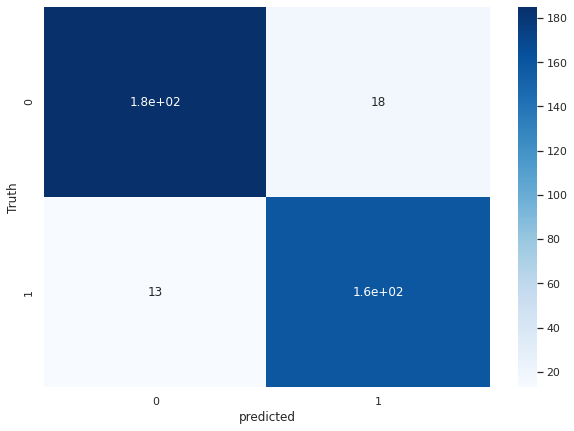

	 ========CLASSIFICATION REPORT=======
	               precision    recall  f1-score   support

       False       0.93      0.91      0.92       203
        True       0.90      0.92      0.91       172

    accuracy                           0.92       375
   macro avg       0.92      0.92      0.92       375
weighted avg       0.92      0.92      0.92       375

	 ========Training Done!=======


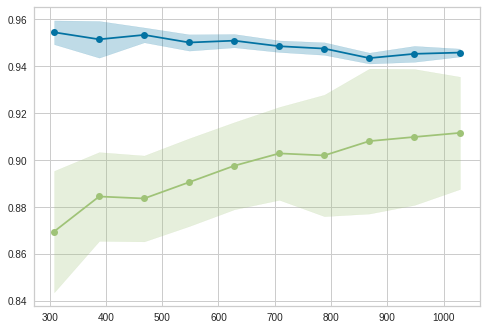

In [ ]:
outlier_scalar = ThressholdScaler()
score_dict_list = []
for imputer_type in imputer_list:
  if imputer_type == 'remove_column_F15':
    data = train_data.copy()
    norm_data = impute_data(imputer_type, data)
    X,y = remove_outliers(norm_data)
    train_model(X,y)
  elif imputer_type == 'iterative_imputer':
    data = train_data.copy()
    norm_data = impute_data(imputer_type, data)
    X,y = remove_outliers(norm_data)
    train_model(X,y)
  elif imputer_type == 'simple_imputer':
    for strategy_type in imputer_strategy_list:
      data = train_data.copy()
      print('STRATEGY: ', strategy_type)
      norm_data = impute_data(imputer_type, data, strategy_type)
      X,y = remove_outliers(norm_data)
      train_model(X,y)
  elif imputer_type == 'knn_imputer':
    data = train_data.copy()
    neighbours = 13
    norm_data = impute_data(imputer_type, data, 'mean', neighbours)
    X,y = remove_outliers(norm_data)
    train_model(X,y)

print('\t \x1b[1;31m'+ '========Training Done!=======' + '\x1b[0m')


#Result

## Best Performing Models

##API to plot Best performing models

In [ ]:
def print_result_plot(plot_score_list, name_list):
  from matplotlib import pyplot
  fig = pyplot.figure(figsize=(10,6)) 
  fig.suptitle('Model Comparison') 
  ax = fig.add_subplot(111) 

  sns.boxplot(data=plot_score_list, width=0.5) 
  ax.set_xticklabels(name_list)
  plt.tick_params(labelsize=15)
  # plt.xticks(rotation=90)
  pyplot.show()

## Extract Best Performing Model

In [ ]:
score_column_name = ['Model','Estimator', 'Scaler', 'Imputer', 'Test_Score', 'CV_MEAN', 'CV_SCORE','Best_Parameters']
all_models = pd.DataFrame(score_dict_list, columns=score_column_name )
all_models = all_models.sort_values(by='Test_Score', ascending=False)
model_list = all_models['Model'].unique()
best_model = []
for model in model_list:
  best_model.append(all_models[ all_models['CV_MEAN'] == (all_models[ all_models['Model'] == model].CV_MEAN.max())])
name = []
cv_scores = []
stack_dict ={}
for mod in best_model:
  stack_dict[mod.values[0][0]] = mod.values[0][1]
  normalize_type = mod.values[0][2]
  imputer_type = mod.values[0][3]
  name.append( mod.values[0][0])
  cv_scores.append( mod.values[0][6])

final_mod_df = pd.DataFrame(all_models[ all_models['CV_MEAN'] == (all_models['CV_MEAN'].max())], columns=score_column_name)
final_mod_df

,Model,Estimator,Scaler,Imputer,Test_Score,CV_MEAN,CV_SCORE,Best_Parameters
0,svm_classifier,"SVC(C=4.789473684210526, break_ties=False, cac...",QuantileScaler,knn_imputer,0.917333,91.463768,"[0.8608695652173913, 0.9130434782608695, 0.904...","{'C': 4.789473684210526, 'gamma': 0.0398107171..."


##BOXPLOT all the Models best performace with 

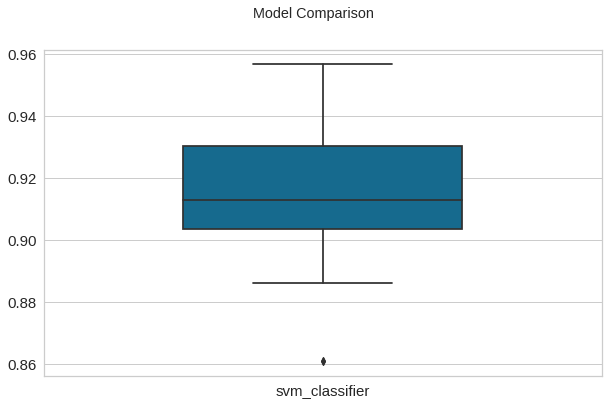

In [ ]:
print_result_plot(cv_scores, name)  

##Print Best Estimator for Each Model

In [ ]:
from tabulate import tabulate

def print_best_estimator(model_name):
  score_column_name = ['Model','Estimator', 'Scaler', 'Imputer', 'Test_Score', 'CV_MEAN', 'CV_SCORE','Best_Parameters']
  all_models = pd.DataFrame(score_dict_list, columns=score_column_name )
  best_estimator = all_models[ all_models['Test_Score'] == (all_models[ all_models['Model'] == model_name].Test_Score.max())]
  # best_estimator = all_models #To get the list of all the resuls for a single model
  best_estimator.drop(columns=['Estimator', 'CV_SCORE'], axis=1, inplace=True)

  print(tabulate(best_estimator,headers=best_estimator.columns))

print_best_estimator('dtree_classifier')
print_best_estimator('svm_classifier')
print_best_estimator('xgboost_classifier')

Model    Scaler    Imputer    Test_Score    CV_MEAN    Best_Parameters
-------  --------  ---------  ------------  ---------  -----------------
    Model           Scaler          Imputer        Test_Score    CV_MEAN  Best_Parameters
--  --------------  --------------  -----------  ------------  ---------  ----------------------------------------------------------------
 0  svm_classifier  QuantileScaler  knn_imputer      0.917333    91.4638  {'C': 4.789473684210526, 'gamma': 0.0398107171, 'kernel': 'rbf'}
Model    Scaler    Imputer    Test_Score    CV_MEAN    Best_Parameters
-------  --------  ---------  ------------  ---------  -----------------


#Stacking

##Applying Stacking with different Scaling Techniques 

In [ ]:
# data = train_data.copy()
# imputed_data = impute_data('knn_imputer', data)
# stacking_cv_score = []
# stacking_names = []
# for normalize_type in scaler_list:
#   X,y = remove_outliers(imputed_data)
#   X = normalize_data(normalize_type, X)
#   data = pd.DataFrame(data, columns=train_data.columns)
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,  random_state=1 )
#   score, cv_mean, stacking_cv_score = stacking_classifier(X_train, y_train, X_test, y_test)
#   # print(f'-------{normalize_type}----------------')
#   print('SCORE :', score )
#   print('CV_MEAN :', cv_mean )
#   stacking_cv_score.append(stacking_cv_score)
#   stacking_names.append(f'Stacking-{normalize_type}')

##Boxplot Stacking

In [ ]:
# print_result_plot(cv_score, names)

#Predictions on Hold-out Test data set

In [ ]:
def prediction_test_set(final_mod_df, data):
  imputer_name = final_mod_df['Imputer'].values[0]
  imputer = imputer_obj[imputer_name]
  scaler_name =  final_mod_df['Scaler'].values[0]
  scaler = scalar_obj[scaler_name]
  clf =  final_mod_df['Estimator'].values[0]

  col_names =(data.columns)
  prediction_features = data.drop(['Class'],axis=1)
  prediction_features = imputer.transform(prediction_features)
  prediction_features = scaler.transform(prediction_features)
  Class = clf.predict(prediction_features)
  prediction_features = pd.DataFrame(data, columns=col_names[:-1])
  prediction_features['Class'] = Class

  return prediction_features


False    818
True     682
Name: Class, dtype: int64


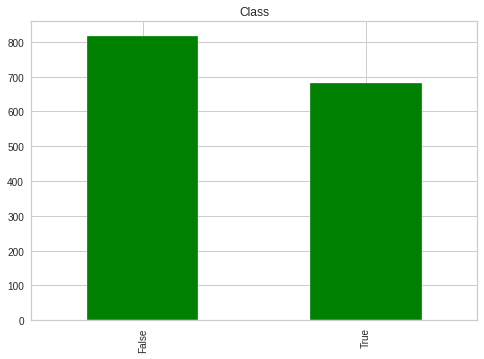

In [ ]:
predictions = prediction_test_set(final_mod_df, test_data)
print(predictions.Class.value_counts())

predictions.Class.value_counts().plot(kind = 'bar', title = 'Class', color=["green"])
final_test_data['Class'] = predictions
# final_test_data.to_csv()

#R&D

In [ ]:
df = train_data.copy()

inputs = df.drop(['Class'],axis=1)
target = df['Class']
col_names =(inputs.columns)

knn = KNNImputer(n_neighbors=3)
inputs = knn.fit_transform(inputs)
inputs = pd.DataFrame(inputs, columns=col_names)
inputs['Class'] = target

x,y = remove_outliers(inputs)

from sklearn.preprocessing import QuantileTransformer
quantile = QuantileTransformer(output_distribution='normal')
x = quantile.fit_transform(x)


# x = inputs
# y = target
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=1)

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
x_train, y_train = smt.fit_sample(x_train, y_train)

svm = SVC(kernel='rbf',C=9.26530612244898)
svm.fit(x_train,y_train)

print(svm.score(x_test,y_test))


df2 = test_data.copy()

test_inputs = df2.drop(['Class'],axis=1)
test_inputs = knn.transform(test_inputs)
test_inputs = quantile.transform(test_inputs)





Number of samples after outlier removal: 1500
0.912


LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7721131d0>,
              cv=10, exploit_incremental_learning=False, groups=None,
              model=None, n_jobs=4, pre_dispatch='all', random_state=None,
              scoring='f1_weighted', shuffle=False,
              train_sizes=array([0.3       , 0.37777778, 0.45555556, 0.53333333, 0.61111111,
       0.68888889, 0.76666667, 0.84444444, 0.92222222, 1.        ]))

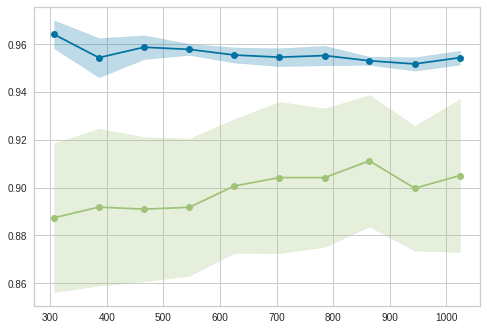

In [ ]:
from yellowbrick.model_selection import LearningCurve
sizes = np.linspace(0.3, 1.0, 10)
model = svm
visualizer = LearningCurve(model, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4)

visualizer.fit(x_train, y_train)        # Fit the data to the visualizer
# visualizer.show() 

False    805
True     695
Name: Class, dtype: int64


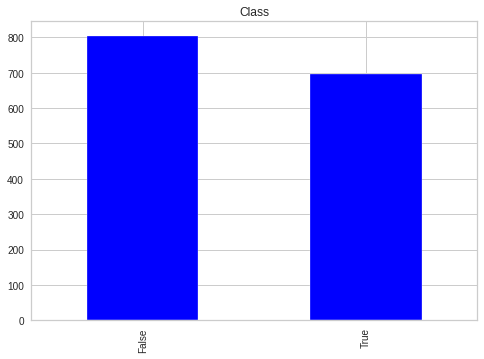

In [ ]:
Class = svm.predict(test_inputs)
test_data['Class'] = Class
print(test_data.Class.value_counts())

test_data.Class.value_counts().plot(kind = 'bar', title = 'Class', color=["blue"])

In [ ]:
def model_grid_search1(model, parameters, X_train, y_train):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  grid_search = GridSearchCV(estimator = model, param_grid = parameters,
                            cv=cv, return_train_score = False, n_jobs = -1,
                            scoring = 'accuracy')
  grid_search.fit(X_train,y_train)
  best_accuracy = grid_search.best_score_
  return  grid_search

In [ ]:
df = train_data.copy()

inputs = df.drop(['Class'],axis=1)
target = df['Class']
col_names =(inputs.columns)

knn = KNNImputer(n_neighbors=18)
inputs = knn.fit_transform(inputs)
inputs = pd.DataFrame(inputs, columns=col_names)
inputs['Class'] = target

x,y = remove_outliers(inputs)

from sklearn.preprocessing import QuantileTransformer
quantile = QuantileTransformer()
x = quantile.fit_transform(x)


# x = inputs
# y = target
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=73)

smt = SMOTETomek(random_state = 1)                   # fixing random state for reproducibility of the model
x_train, y_train = smt.fit_sample(x_train, y_train)

svm = SVC(kernel='rbf',C=13)
svm.fit(x_train,y_train)

print(svm.score(x_test,y_test))


df2 = test_data.copy()

test_inputs = df2.drop(['Class'],axis=1)
test_inputs = knn.transform(test_inputs)
test_inputs = quantile.transform(test_inputs)





Number of samples after outlier removal: 1500
0.9306666666666666


LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc788d38e48>,
              cv=10, exploit_incremental_learning=False, groups=None,
              model=None, n_jobs=4, pre_dispatch='all', random_state=None,
              scoring='f1_weighted', shuffle=False,
              train_sizes=array([0.3       , 0.37777778, 0.45555556, 0.53333333, 0.61111111,
       0.68888889, 0.76666667, 0.84444444, 0.92222222, 1.        ]))

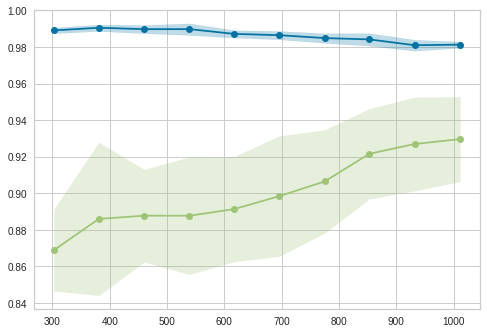

In [ ]:
from yellowbrick.model_selection import LearningCurve
sizes = np.linspace(0.3, 1.0, 10)
model = svm
visualizer = LearningCurve(model, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4)

visualizer.fit(x_train, y_train)        # Fit the data to the visualizer
# visualizer.show() 

False    795
True     705
Name: Class, dtype: int64


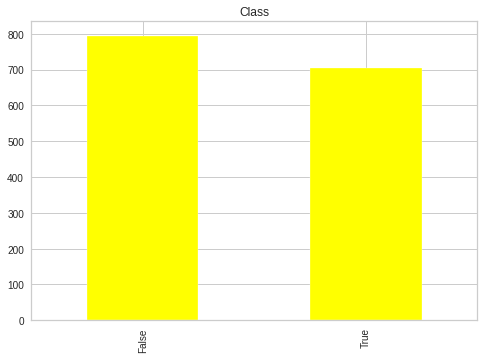

In [ ]:
Class = svm.predict(test_inputs)
test_data['Class'] = Class
print(test_data.Class.value_counts())

test_data.Class.value_counts().plot(kind = 'bar', title = 'Class', color=["yellow"])